In [ ]:
import os
import numpy as np
import rasterio
from src import pipeline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import linregress
from datetime import datetime
from scipy import stats
from rasterio.plot import reshape_as_image
from datetime import date
import glob
import pandas as pd

### Read Classification Stack

In [18]:
# ---------------------------------
# 1. Input setup
# ---------------------------------
data_dir = ""
files = sorted(glob.glob(os.path.join(data_dir, "output/classified/*_classified.tif")))
years = [os.path.basename(f) for f in files]
print("Found years:", years)

# ---------------------------------
# 2. Read and stack rasters (classifications)
# ---------------------------------
stack = []
meta = None
for f in files:
    with rasterio.open(f) as src:
        data = src.read(1)
        stack.append(data)
        if meta is None:
            meta = src.meta

stack = np.stack(stack, axis=0)  # shape: (time, H, W)
H, W = stack.shape[1:]
print("Stack shape:", stack.shape)

Found years: ['LC08_L2SP_109060_20131017_20200912_02_T1_classified.tif', 'LC08_L2SP_109060_20160212_20200907_02_T1_classified.tif', 'LC08_L2SP_109060_20160603_20200907_02_T1_classified.tif', 'LC08_L2SP_109060_20161110_20200905_02_T1_classified.tif', 'LC08_L2SP_109060_20170505_20200904_02_T1_classified.tif', 'LC08_L2SP_109060_20171012_20200903_02_T1_classified.tif', 'LC08_L2SP_109060_20171231_20200902_02_T1_classified.tif', 'LC08_L2SP_109060_20180508_20200901_02_T1_classified.tif', 'LC08_L2SP_109060_20180727_20200831_02_T1_classified.tif', 'LC08_L2SP_109060_20181031_20200830_02_T1_classified.tif', 'LC08_L2SP_109060_20190204_20200829_02_T1_classified.tif', 'LC08_L2SP_109060_20190527_20200828_02_T1_classified.tif', 'LC08_L2SP_109060_20190916_20200826_02_T1_classified.tif', 'LC08_L2SP_109060_20191205_20200825_02_T1_classified.tif', 'LC08_L2SP_109060_20200122_20200823_02_T1_classified.tif', 'LC08_L2SP_109060_20200310_20200822_02_T1_classified.tif', 'LC08_L2SP_109060_20210108_20210307_02_T1_

### Read Landsat images and calculate NDVI

In [39]:
ndvi_stack = np.empty(stack.shape,np.float32)
#ndvi_stack.dtype == np.float32

img_folder_path = "data/stacked/"

for n, img_name in enumerate(os.listdir(img_folder_path)):

    img_path = img_folder_path + img_name + "/" + img_name
    with rasterio.open(img_path) as src:
        bands, band_names, band_to_index, profile = pipeline.get_bands_from_stack(img_path)

        sensor = img_name[0:4]
        #img = src.read()
        #profile = src.profile
        #rgb = reshape_as_image(img)[:, :, :3]  # for display
        #transform = src.transform
        red = bands[band_to_index[pipeline.band_map[sensor]['R']] - 1]
        nir = bands[band_to_index[pipeline.band_map[sensor]['NIR']] - 1]

        ndvi = np.where(
                (nir + red) == 0, np.nan,
                (nir - red) / (nir + red)
            )
        ndvi_stack[n, :, :] = ndvi





C:\Users\oneil\AppData\Local\Temp\ipykernel_9952\4125008184.py:22: RuntimeWarning: invalid value encountered in divide
  (nir - red) / (nir + red)


### Get dates of each image (as integer in days)

In [64]:
dates_str = [y.split("_")[3] for y in years]
dates_dt = np.array([datetime.strptime(dt, '%Y%m%d') for dt in dates_str])
dates_int = dates_dt.astype('datetime64[D]').astype(float)

### Calculate ENVI trend in each pixel

In [133]:
trend_stack = np.empty(stack.shape[1:],np.float32)
count_stack = np.empty(stack.shape[1:],np.int16)

def basic_regression(x,y):
    x_mean = x.mean()
    y_mean = y.mean()
    slope = np.sum((x - x_mean) * (y - y_mean)) / np.sum((x - x_mean) ** 2)
    return slope

for y in range(H):

    for x in range(W):
        s = stack[:,y,x]
        ndvi_s = ndvi_stack[:,y,x]
        s_filter = ((s == 1) & ~np.isnan(ndvi_s))
        count_stack[y,x] = s_filter.sum()
        if s_filter.sum() < 5:
            trend_stack[y,x] = np.nan
            continue
        ndvi_filt = ndvi_s[s_filter]
        dates_filt = dates_int[s_filter]
        slope_xy = basic_regression(dates_filt,ndvi_filt)
        trend_stack[y,x] = slope_xy
    # print progress
    if y % 100 == 99:
        comp_perc = int(100*y/H)
        print(f"{comp_perc}% complete")

        


7% complete
15% complete
23% complete
30% complete
38% complete
46% complete
54% complete
61% complete
69% complete
77% complete
85% complete
92% complete


### Get final classification state from file

In [140]:
path = "output/classified/jungle_to_mine_change.tif"

with rasterio.open(path) as src:
    initial_state = src.read(1)
    final_state = src.read(2)
    change_year = src.read(3)

final_state_no_forest = final_state.astype(float)
forest_mask = (final_state==1)
final_state_no_forest[forest_mask] = np.nan

### Plot NDVI trends on a map

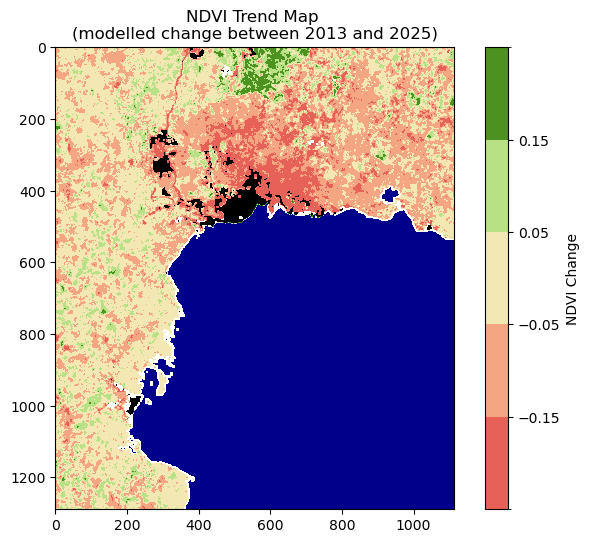

In [151]:
# Define the boundaries (edges between color ranges)
#bounds = [-9999, -0.00006, -0.00002,  0.00002, 0.00006, 9999]
bounds = [-9999, -0.15, -0.05,  0.05, 0.15, 9999]

# Define the colors for each range (one fewer than the number of bounds)
colors = ['#e66158', '#f4a582', "#F3E8B3", '#b8e186', '#4d9221']

# Create colormap and normalization
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, cmap.N)

trend_stack_scaled = trend_stack*365*13 #trend_stack is daily trend, make it over the 13-year period

# Plot
plt.figure(figsize=(8, 6))
im = plt.imshow((trend_stack_scaled), cmap=cmap, norm=norm) 
plt.colorbar(im, boundaries=bounds, ticks=bounds[1:-1], label="NDVI Change")
plt.title("NDVI Trend Map \n(modelled change between 2013 and 2025)")
#plt.show()


classes = {
    3: ("Ocean", "deepskyblue"),
    0: ("Cloud", "lightgrey"),
    1: ("Jungle", "forestgreen"),
    2: ("Cleared", "black"),
    -1: ("No data", "darkblue")
}

# Sort class values to match colormap
class_values = sorted(classes.keys())
class_colors = [classes[c][1] for c in class_values]
#class_labels = [classes[c][0] for c in class_values[2:3]]

# Create colormap and norm
class_cmap = mcolors.ListedColormap(class_colors)
# Boundaries should extend ±0.5 around each integer value
class_bounds = [c - 0.5 for c in class_values] + [class_values[-1] + 0.5]
class_norm = mcolors.BoundaryNorm(class_bounds, class_cmap.N)

# Plot
im = plt.imshow(final_state_no_forest, cmap=class_cmap, norm=class_norm)
#cbar = plt.colorbar(im, ticks=class_values)
#cbar.ax.set_yticklabels(class_labels)



### Calculate distance to mine site (using final state)

In [144]:
from scipy.ndimage import distance_transform_edt

# Boolean mask of "2" pixels
mask_2 = (final_state == 2)

# Compute Euclidean distance from every pixel to the nearest "2" pixel
dist_to_2 = distance_transform_edt(~mask_2)

# Mask so only class 1 pixels show distance (others as NaN)
dist_plot = np.full_like(dist_to_2, np.nan, dtype=float)
dist_plot[final_state == 1] = dist_to_2[final_state == 1]

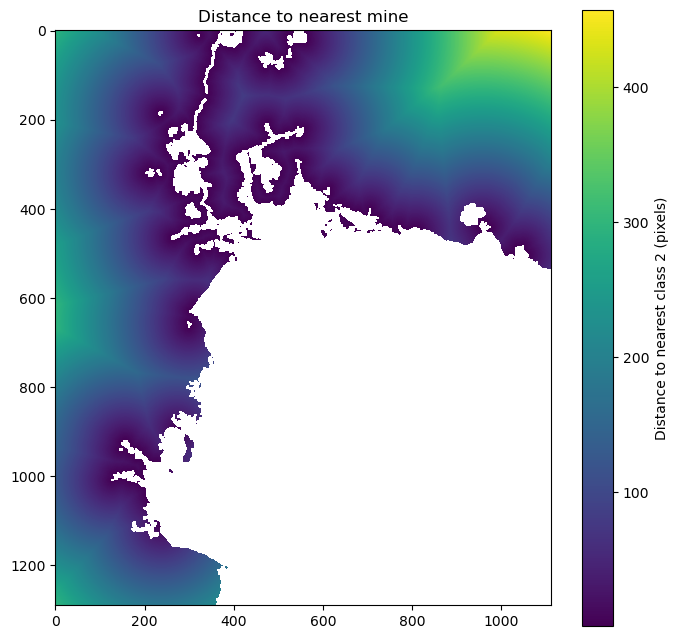

In [156]:
#Plot
plt.figure(figsize=(8, 8))
im = plt.imshow(dist_plot, cmap='viridis')
plt.colorbar(im, label='Distance to nearest class 2 (pixels)')
plt.title('Distance to nearest mine')
plt.show()

### Calculate relationship between NDVI and distance to a mine

Slope: 4.9626730246785766e-05
Intercept: -0.04390067047775285
R-squared: 0.002646946774467095
P-value: 0.0


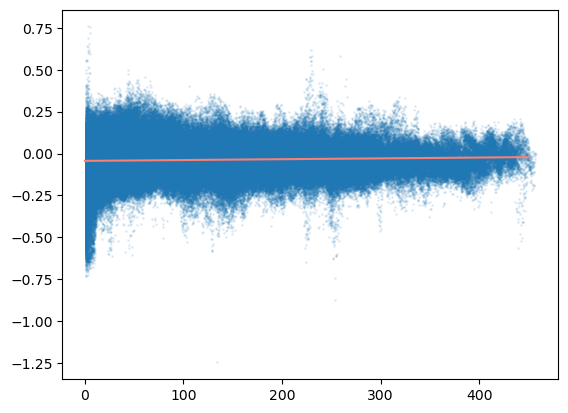

In [ ]:
# Flattened arrays
x = dist_plot.flatten()
y = trend_stack_scaled.flatten()

plt.scatter(x,y, alpha = 0.1,s=1)

# Remove NaNs
mask = ~np.isnan(x) & ~np.isnan(y)
x = x[mask]
y = y[mask]

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x, y)

r_squared = r_value**2

print(f"Slope: {slope}")
print(f"Intercept: {intercept}")
print(f"R-squared: {r_squared}")
print(f"P-value: {p_value}")

reg_line_max = 450

plt.plot([0,reg_line_max],[intercept,intercept+slope*reg_line_max], c = 'salmon')
